In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
#step 1: read data from S3

In [3]:
movies_8000 = pd.DataFrame(pd.read_pickle('s3://moive-rating/IMDb_8000.pickle'))
df1 = pd.DataFrame(pd.read_pickle('s3://moive-rating/IMDb_top_movies.pickle'))
df2 = pd.DataFrame(pd.read_pickle('s3://moive-rating/IMDb_top_2000s.pickle'))
movies_8100 = pd.concat([movies_8000,df1,df2])

In [4]:
movies_8100 = movies_8100.drop(['country','language'],axis=1)

In [5]:
#keep the original data
movies_df = movies_8100.copy()
movies_df.drop_duplicates(subset=['movie title'],inplace=True)

In [6]:
#step 2: explore data (clean data)

In [7]:
# Drop movies without budget data
movies_df.set_index('movie title',inplace=True)
movies_df = movies_df.dropna(subset=['budget'])

In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2655 entries, Mulan to Cinderella Man
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb rating           2495 non-null   float64
 1   imdb raters           2495 non-null   float64
 2   mpaa                  1581 non-null   object 
 3   genres                2654 non-null   object 
 4   director              2652 non-null   object 
 5   writer                2651 non-null   object 
 6   stars                 2594 non-null   object 
 7   release date          2464 non-null   object 
 8   budget                2655 non-null   float64
 9   opening weekend       931 non-null    float64
 10  gross usa             957 non-null    float64
 11  cumulative worldwide  1118 non-null   float64
 12  production companies  2480 non-null   object 
 13  runtime (min)         2382 non-null   float64
dtypes: float64(7), object(7)
memory usage: 311.1+ KB


In [9]:
movies_df.sample(5)

,imdb rating,imdb raters,mpaa,genres,director,writer,stars,release date,budget,opening weekend,gross usa,cumulative worldwide,production companies,runtime (min)
movie title,,,,,,,,,,,,,,
Sleepless,5.6,29418.0,R,"[Action, Crime, Thriller]",Baran bo Odar,Andrea Berloff,"[Jamie Foxx, Michelle Monaghan, Dermot Mulroney]",2017-01-13,30000000.0,8344128.0,20783704.0,32917353.0,"[Open Road Films (II), Stage 6 Films, Riversto...",NaN
My All-American,7.2,5866.0,PG,"[Biography, Drama, Sport]",Angelo Pizzo,Angelo Pizzo,"[Aaron Eckhart, Finn Wittrock, Robin Tunney]",2015-11-13,20000000.0,1365000.0,2246000.0,2246000.0,"[Anthem Productions, Paul Schiff Productions]",118.0
The Hero,6.5,7891.0,R,"[Drama, Romance, Western]",Brett Haley,Brett Haley,"[Sam Elliott, Laura Prepon, Krysten Ritter]",2017-06-09,1200000.0,45317.0,4077333.0,4101699.0,"[Houston King Productions, Northern Lights Fil...",96.0
Stronger,6.9,39324.0,R,"[Biography, Drama]",David Gordon Green,John Pollono,"[Jake Gyllenhaal, Tatiana Maslany, Miranda Ric...",2017-09-29,30000000.0,1611040.0,4211129.0,8503658.0,"[Lionsgate, Bold Films, TIK Films]",119.0
Heaven Bound,6.9,48.0,None,[Comedy],Gabe McCauley,Rene Gutteridge,"[Colleen Addair, Denny Brownlee, Jamie Costa]",2017-03-27,500000.0,NaN,NaN,NaN,"[Drake Films, Torrent Entertainment]",95.0


In [10]:
#Fill rows with empy MPAA with 'N/A'
movies_df['mpaa'].fillna('N/A', inplace=True)
movie_df = movies_df[movies_df['imdb rating'].notna()]

movie_df = movie_df[movie_df['imdb raters'] >= 10000]
movie_df = movie_df[movie_df['budget'] >= 10000]
movie_df = movie_df[movie_df['runtime (min)'].notna()]

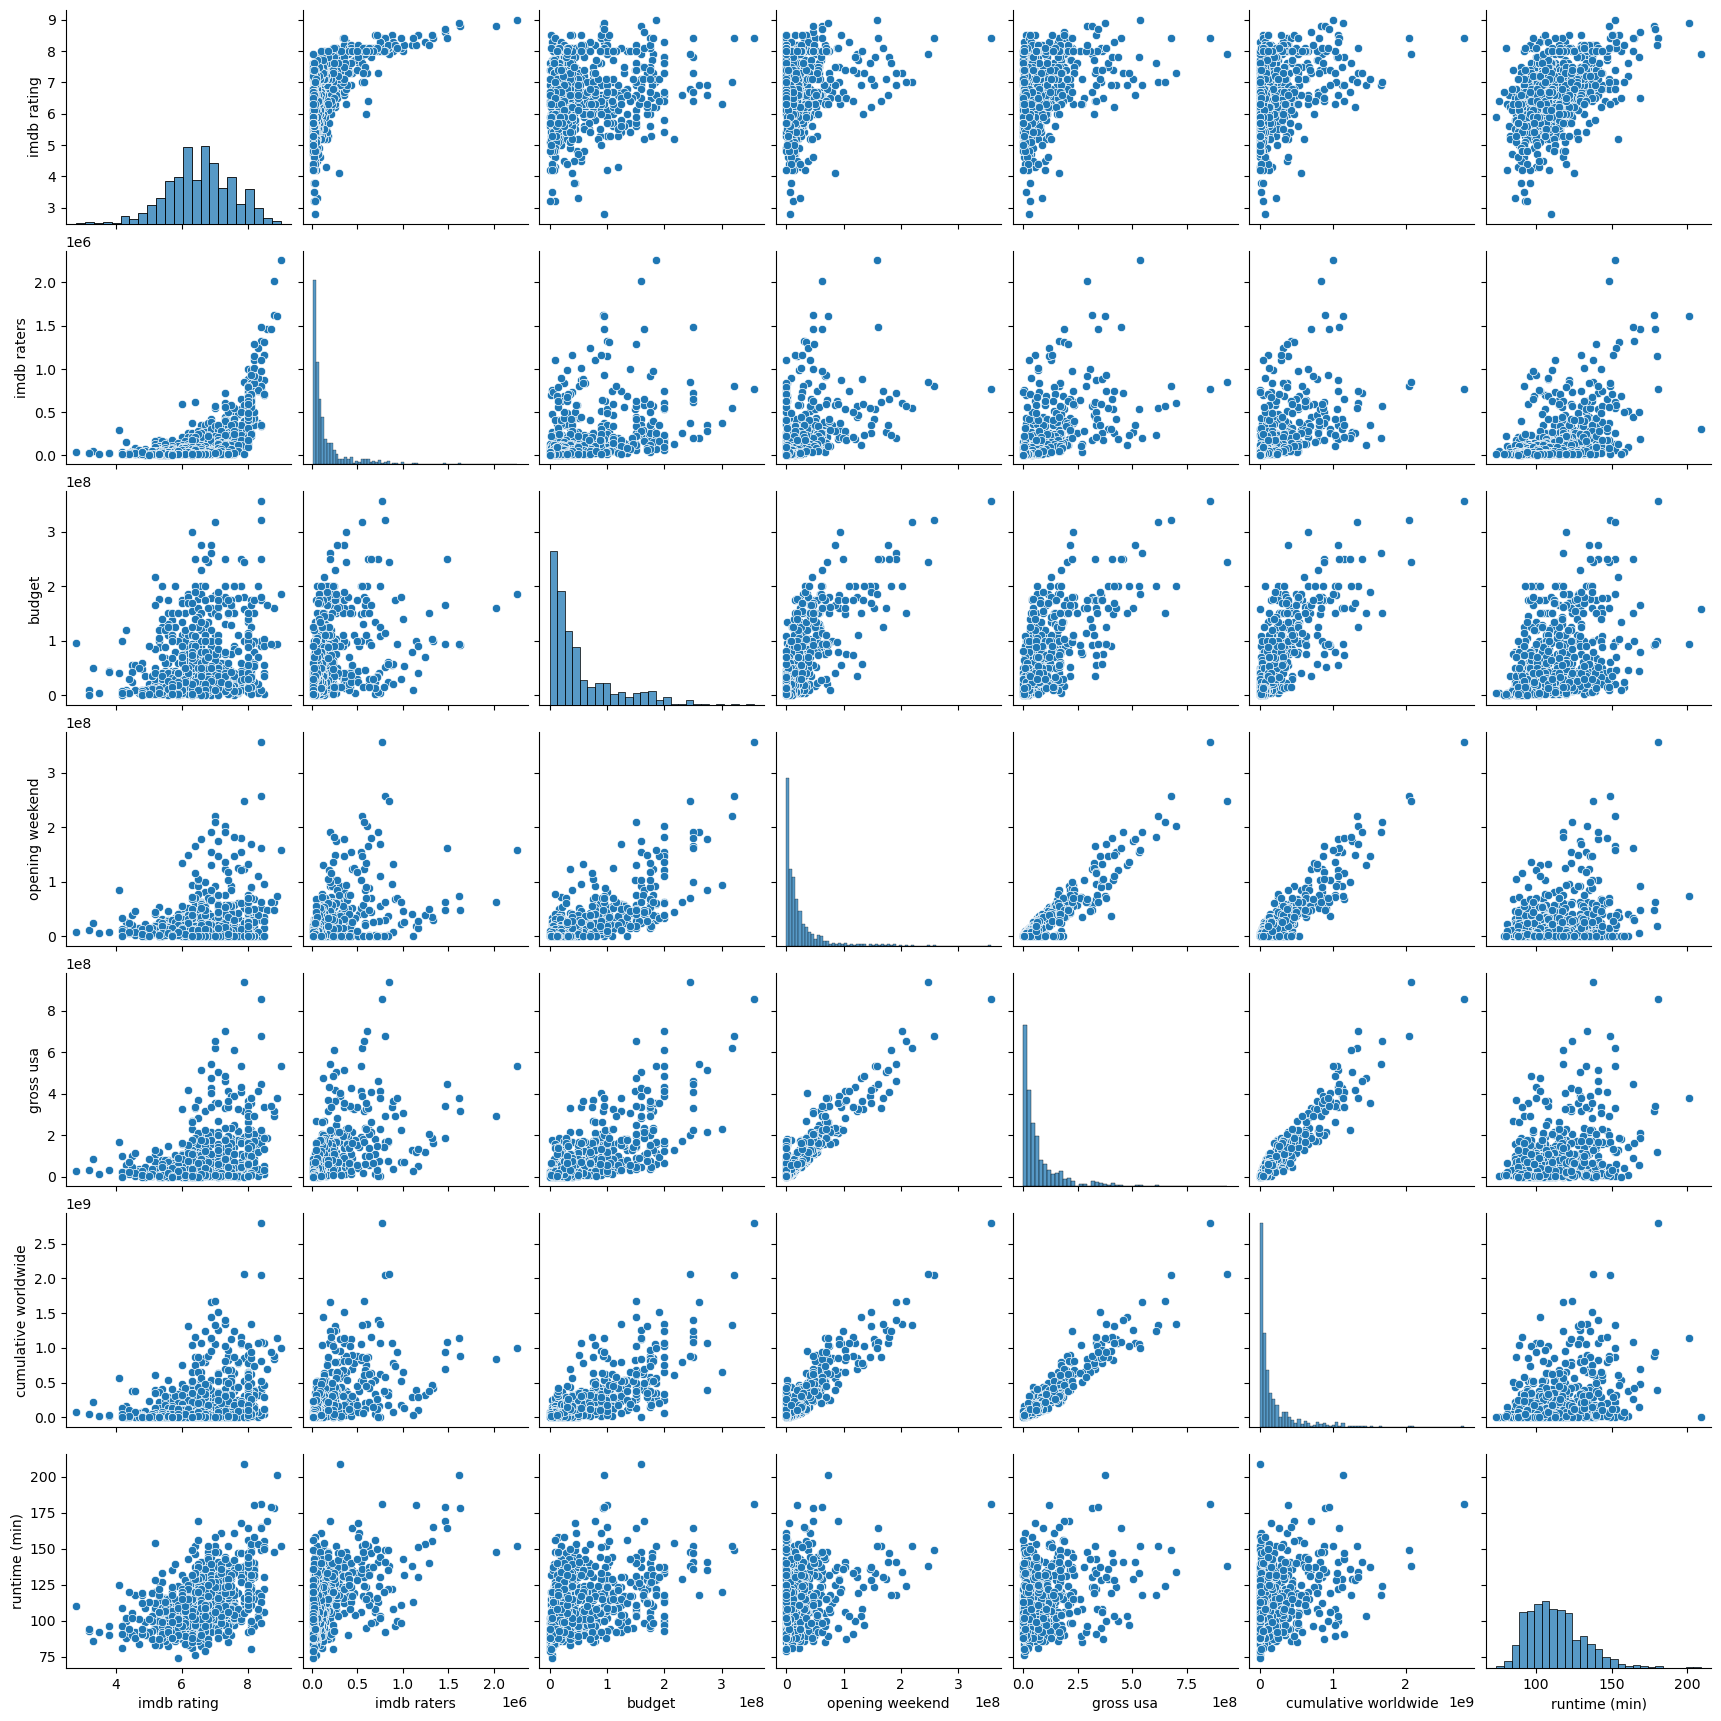

In [11]:
sns.pairplot(movie_df)

In [12]:
#step 3: feature engineering

In [13]:
#feature: mpaa
mpaa_df = pd.get_dummies(movie_df['mpaa'])
df_added_mpaa_dummies = pd.concat([movie_df,mpaa_df], axis=1)
df_added_mpaa_dummies = df_added_mpaa_dummies.drop('mpaa',axis=1)
df_added_mpaa_dummies = df_added_mpaa_dummies.drop(['Not Rated','Unrated','N/A'],axis=1)

In [14]:
#feature: genres
df_genres_added = pd.Series(df_added_mpaa_dummies['genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum()

df_genres_mpaa = pd.concat([df_added_mpaa_dummies, df_genres_added], axis=1)
df_genres_mpaa.drop(labels=['opening weekend','gross usa','cumulative worldwide'],axis=1,inplace=True)
df_genres_mpaa = df_genres_mpaa.drop('genres',axis=1)
df_genres_mpaa = df_genres_mpaa.drop('imdb raters',axis=1)

In [15]:
#feature: directors

empty_dir = movie_df[movie_df['director']==''].index.values.tolist()
dir_fill = [
    'Peter Ramsey, Bob Persichetti, Rodney Rothman',
    'Ron Clements, John Musker',
    'Byron Howard, Rich Moore',
    'Pierre Coffin, Chris Renaud',
    'Charlie Bean, Bob Logan, Paul Fisher',
    'Frank Miller, Quentin Tarantino, Robert Rodriguez',
    'Dan Scanlon, Saschka Unseld'
    ]
for num, movie in enumerate(empty_dir):
    movie_df['director'][movie] = dir_fill[num]

In [16]:
def directors_list(directors):
    """
    Separates a string of directors into a list of the separate directors.
    Args:
        directors: A string of directors separated by commas
    Returns:
        A list of directors.
    """
    if "," in directors:
        return [name.strip() for name in directors.split(",")]
    else:
        return [directors]


def remove_paren(directors):
    """
    Takes off aliases that are in parentheses next to a director's name
    Args:
        directors: A list of directors
    Returns:
        The same list of directors, but without aliases in parenthesis.
    """
    dir_list = []
    for director in directors:
        if "(" in director:
            dir_clean = director.split("(")[0].strip()
            dir_list.append(dir_clean)
        else:
            dir_list.append(director)
    return dir_list


In [17]:
movie_df['director'] = movie_df['director'].apply(lambda x: directors_list(x))
movie_df['director'] = movie_df['director'].apply(lambda x: remove_paren(x))

In [18]:
df_dir_exploded = movie_df.explode('director')
dir_10 = df_dir_exploded['director'].value_counts()[:10].index.tolist()
def top_directors(directors):
    dir_list = []
    for director in directors:
        if director in dir_10:
            dir_list.append(director)
    return dir_list

movie_df['top'] = movie_df['director'].apply(lambda x: top_directors(x))
dir_df = pd.get_dummies(movie_df['top'].apply(pd.Series).stack()).sum()
# merge dirctor feature in dataframe
df_dir_model = pd.concat([df_genres_mpaa, dir_df], axis=1)
df_dir_model.replace(np.nan,0,inplace=True)


In [19]:
#feature: writer
writ_df = pd.get_dummies(movie_df['writer'])
writ_10 = movie_df.writer.value_counts()[:10].index.tolist() #consider top 10 writers
df_writ_model = pd.concat([df_dir_model,writ_df[writ_10]],axis=1)


In [20]:
#feature: star
stars_exploded = movie_df.explode('stars')
stars_20 = stars_exploded['stars'].value_counts()[:20].index.tolist()
#take the top 20 stars 
def top_stars(stars):
    star_list = []
    for star in stars:
        if star in stars_20:
            star_list.append(star)
    return star_list

movie_df['top stars'] = movie_df['stars'].apply(lambda x: top_stars(x))
stars_df = pd.get_dummies(movie_df['top stars'].apply(pd.Series).stack()).sum()
star_model = pd.concat([df_writ_model, stars_df[stars_20]], axis=1)
star_model.replace(np.nan,0,inplace=True)


In [21]:
#feature: production companies
prod_exploded = movie_df.explode('production companies')
prod_15 = prod_exploded['production companies'].value_counts()[:15].index.tolist()
movie_df.loc[movie_df['production companies'].isnull(),'production companies'] = movie_df.loc[movie_df['production companies'].isnull(),'production companies'].apply(lambda x: [])
def top_prod(comp):
    comp_list = []
    for co in comp:
        if co in prod_15:
            comp_list.append(co)
    return comp_list
movie_df['top prod co.'] = movie_df['production companies'].apply(lambda x: top_prod(x))
prod_df = pd.get_dummies(movie_df['top prod co.'].apply(pd.Series).stack()).sum()
#merge feature into dataframe
prod_model = pd.concat([star_model, prod_df[prod_15]], axis=1)
prod_model.replace(np.nan,0,inplace=True)

In [22]:
#feature: years since release
date = pd.to_datetime(datetime.now().date())
movie_df['years since release'] = movie_df['release date'].apply(lambda x: (((date-pd.to_datetime(x))).days/ 365.25))
prod_model['years since release'] = movie_df['years since release']
prod_model = prod_model.drop(['director','stars','release date','production companies'],axis=1)


In [23]:
remove_cols =[col for col in prod_model.columns if col==0]

In [24]:
prod_model.drop(remove_cols, axis='columns', inplace=True)

In [25]:
prod_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, Mulan to LStar Capital
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb rating          895 non-null    float64
 1   writer               895 non-null    object 
 2   budget               895 non-null    float64
 3   runtime (min)        895 non-null    float64
 4   G                    895 non-null    object 
 5   PG                   895 non-null    object 
 6   PG-13                895 non-null    object 
 7   R                    895 non-null    object 
 8   TV-MA                895 non-null    object 
 9   Quentin Tarantino    895 non-null    object 
 10  Jonathan Aibel       895 non-null    object 
 11  Jonathan Nolan       895 non-null    object 
 12  Christina Hodson     895 non-null    object 
 13  Leigh Whannell       895 non-null    object 
 14  Taylor Sheridan      895 non-null    object 
 15  Jon Lucas            895 non-nu

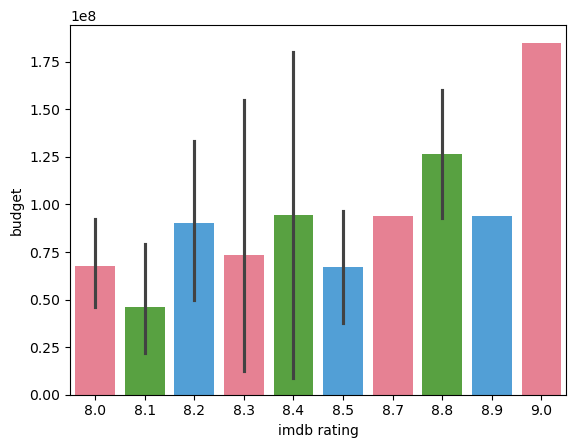

In [26]:
sns.barplot(x='imdb rating', y ='budget', data=df2, palette = sns.color_palette("husl", 3));

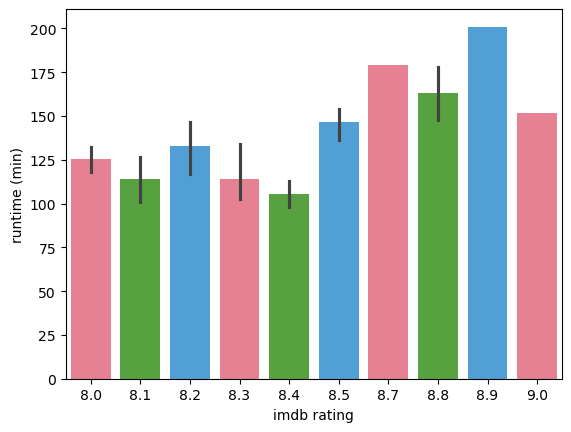

In [27]:
sns.barplot(x='imdb rating', y ='runtime (min)', data=df2, palette = sns.color_palette("husl", 3));

In [28]:
X, y = prod_model.iloc[:,2:], prod_model['imdb rating']

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, Mulan to LStar Capital
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   budget               895 non-null    float64
 1   runtime (min)        895 non-null    float64
 2   G                    895 non-null    object 
 3   PG                   895 non-null    object 
 4   PG-13                895 non-null    object 
 5   R                    895 non-null    object 
 6   TV-MA                895 non-null    object 
 7   Quentin Tarantino    895 non-null    object 
 8   Jonathan Aibel       895 non-null    object 
 9   Jonathan Nolan       895 non-null    object 
 10  Christina Hodson     895 non-null    object 
 11  Leigh Whannell       895 non-null    object 
 12  Taylor Sheridan      895 non-null    object 
 13  Jon Lucas            895 non-null    object 
 14  Max Landis           895 non-null    object 
 15  Rhett Reese          895 non-nu

In [30]:
X = X.fillna(0)

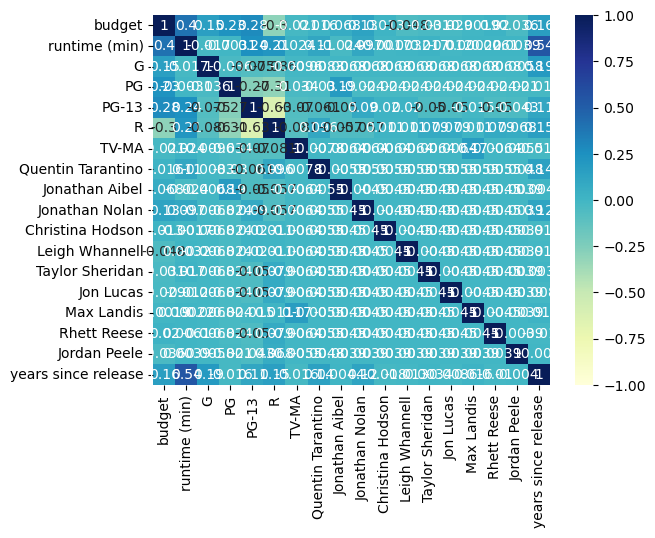

In [31]:
cormatrix= X.corr()
heatmap = sns.heatmap(cormatrix, cmap='YlGnBu', annot=True, vmin=-1, vmax=1)
sns.set(font_scale=1)
figure = heatmap.get_figure()
figure.savefig('heatmap.jpg', bbox_inches='tight', dpi=200)

In [32]:
#step 4: explore the important features

In [33]:
features = list(X.columns)
print(features)

['budget', 'runtime (min)', 'G', 'PG', 'PG-13', 'R', 'TV-MA', 'Quentin Tarantino', 'Jonathan Aibel', 'Jonathan Nolan', 'Christina Hodson', 'Leigh Whannell', 'Taylor Sheridan', 'Jon Lucas', 'Max Landis', 'Rhett Reese', 'Jordan Peele', 'years since release']


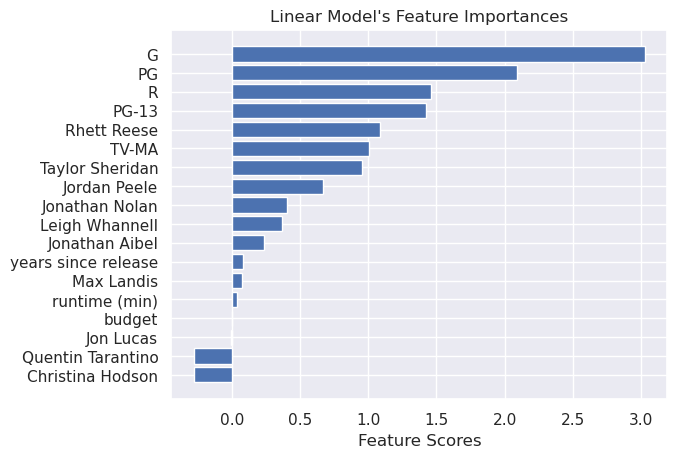

<Figure size 640x480 with 0 Axes>

In [34]:
model = LinearRegression()
model.fit(X, y)
importance = model.coef_
#for i,v in enumerate(importance):
 #print('Feature: %0d, Score: %.4f' % (i,v))
indices = np.argsort(importance)

plt.title("Linear Model's Feature Importances")
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Scores')
plt.show()
plt.savefig('Linear_FeatureImportances.png')

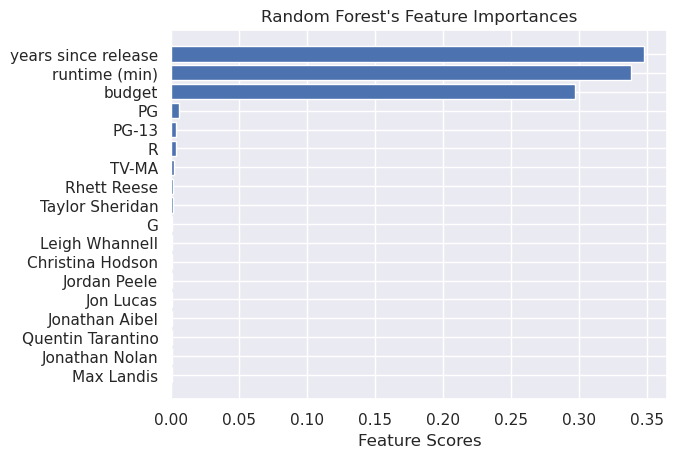

<Figure size 640x480 with 0 Axes>

In [35]:
# random forest for feature importance on a regression problem
model = RandomForestRegressor()
model.fit(X, y)
importance = model.feature_importances_
indices = np.argsort(importance)

plt.title("Random Forest's Feature Importances")
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Scores')
plt.show()
plt.savefig('RandomForest_FeatureImportances.png')

In [36]:
#step 5: modeling

In [37]:
#Create X_train, X_test, y_train, y_test
X, y = prod_model.iloc[:,2:], prod_model['imdb rating']
cols = list(X.columns)
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)


In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, Criminal to Lights Out
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   budget               716 non-null    float64
 1   runtime (min)        716 non-null    float64
 2   G                    716 non-null    object 
 3   PG                   716 non-null    object 
 4   PG-13                716 non-null    object 
 5   R                    716 non-null    object 
 6   TV-MA                716 non-null    object 
 7   Quentin Tarantino    716 non-null    object 
 8   Jonathan Aibel       716 non-null    object 
 9   Jonathan Nolan       716 non-null    object 
 10  Christina Hodson     716 non-null    object 
 11  Leigh Whannell       716 non-null    object 
 12  Taylor Sheridan      716 non-null    object 
 13  Jon Lucas            716 non-null    object 
 14  Max Landis           716 non-null    object 
 15  Rhett Reese          716 non-nu

In [39]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [40]:
y_pred = lr.predict(X_test)

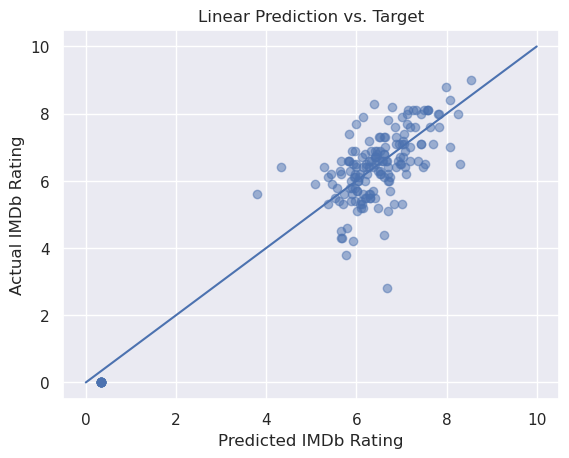

In [41]:
plt.scatter(y_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Linear Prediction vs. Target')
plt.xlabel('Predicted IMDb Rating')
plt.ylabel('Actual IMDb Rating')
plt.savefig('LinearRegression_model.png')

In [42]:
print('Linear regression R-squared: {:.4f}'.format(r2_score(y_test, y_pred))) 

Linear regression R-squared: 0.8293


In [43]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 2, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 2, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    

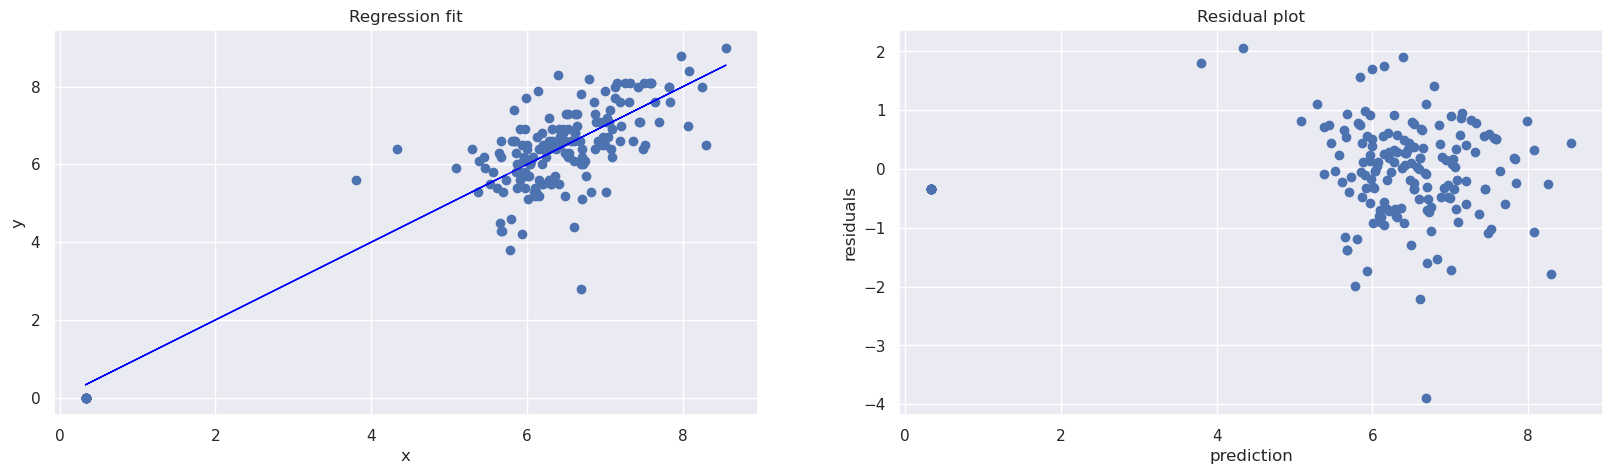

In [44]:
diagnostic_plot(y_pred, y_test)

In [45]:
#random forest regression
rf = RandomForestRegressor()

In [46]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [47]:
y_pred1 = rf.predict(X_test)

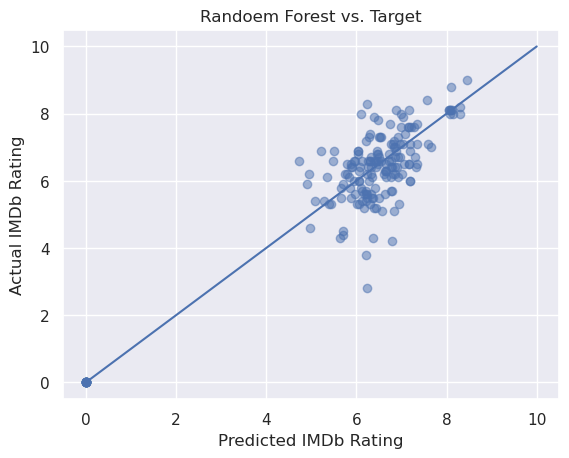

In [48]:
plt.scatter(y_pred1, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Randoem Forest vs. Target')
plt.xlabel('Predicted IMDb Rating')
plt.ylabel('Actual IMDb Rating')
plt.savefig('RandomForest_model.png')

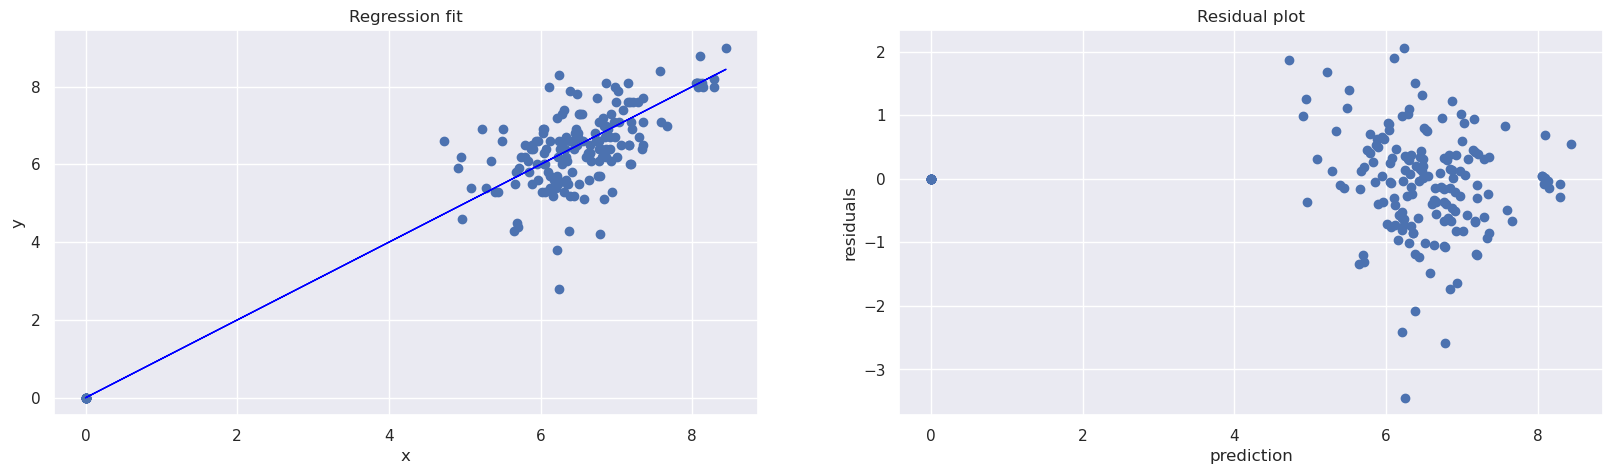

In [49]:
diagnostic_plot(y_pred1, y_test)

In [50]:
print('Linear regression R-squared: {:.4f}'.format(r2_score(y_test, y_pred1))) 

Linear regression R-squared: 0.8302
